In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, precision_score, recall_score
import joblib
import time

## Load Dataset

In [2]:
df = pd.read_csv("Loan_default.csv")

selected_features = [
    "Income", "InterestRate", "LoanAmount", "Age", 
    "CreditScore", "MonthsEmployed", "DTIRatio"
]

X = df[selected_features]
y = df["Default"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dataset shapes:")
print(f"Training: {X_train.shape}, Testing: {X_test.shape}")
print(f"Default rate: {y.mean():.3f}")


Dataset shapes:
Training: (204277, 7), Testing: (51070, 7)
Default rate: 0.116


### Dictionary to store results

In [5]:
results = {}
training_times = {}


### logistic Regression

In [6]:
print("\n" + "="*50)
print("1. TRAINING LOGISTIC REGRESSION")
print("="*50)

start_time = time.time()
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
lr_time = time.time() - start_time
training_times['Logistic Regression'] = lr_time

lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

results['Logistic Regression'] = {
    'predictions': lr_pred,
    'probabilities': lr_pred_proba,
    'model': lr_model
}

print(f"Training time: {lr_time:.2f} seconds")


1. TRAINING LOGISTIC REGRESSION
Training time: 0.11 seconds


In [7]:
print("\n" + "="*50)
print("2. TRAINING RANDOM FOREST")
print("="*50)

start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_time = time.time() - start_time
training_times['Random Forest'] = rf_time

rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

results['Random Forest'] = {
    'predictions': rf_pred,
    'probabilities': rf_pred_proba,
    'model': rf_model
}

print(f"Training time: {rf_time:.2f} seconds")


2. TRAINING RANDOM FOREST
Training time: 3.51 seconds


In [8]:
print("\n" + "="*50)
print("3. TRAINING XGBOOST")
print("="*50)

start_time = time.time()
xgb_model = XGBClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    eval_metric='logloss',
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_time = time.time() - start_time
training_times['XGBoost'] = xgb_time

xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

results['XGBoost'] = {
    'predictions': xgb_pred,
    'probabilities': xgb_pred_proba,
    'model': xgb_model
}

print(f"Training time: {xgb_time:.2f} seconds")


3. TRAINING XGBOOST
Training time: 0.90 seconds


In [9]:
print("\n" + "="*50)
print("4. TRAINING 1D CNN")
print("="*50)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer, Conv1D, BatchNormalization, MaxPooling1D,
    GlobalMaxPooling1D, Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_cnn_1d(input_shape, drop_rate=0.3):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model


4. TRAINING 1D CNN


2025-11-26 17:35:10.440814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Prepare data for CNN
X_train_cnn = np.expand_dims(X_train_scaled, axis=2)
X_test_cnn = np.expand_dims(X_test_scaled, axis=2)

n_features = X_train.shape[1]
cnn_model = build_cnn_1d((n_features, 1))

print("CNN Model Summary:")
cnn_model.summary()

# CNN callbacks
cnn_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
]

# Train CNN
start_time = time.time()
cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=cnn_callbacks,
    verbose=1
)
cnn_time = time.time() - start_time
training_times['1D CNN'] = cnn_time

/home/stonie/miniconda3/lib/python3.13/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1764167747.837402   19515 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1022 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:07:00.0, compute capability: 8.6


CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,049 (133.00 KB)

 Trainable params: 33,665 (131.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10


2025-11-26 17:35:50.035414: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f9e3800f680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-26 17:35:50.035433: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-11-26 17:35:50.076433: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-26 17:35:50.333262: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-26 17:35:50.464876: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 17:35:50.464928: I e

 107/5107 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8237 - auc: 0.6058 - loss: 0.4496

I0000 00:00:1764167753.938624   20056 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5071/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8791 - auc: 0.6916 - loss: 0.3466

2025-11-26 17:36:01.404035: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 17:36:01.981457: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_716', 28 bytes spill stores, 28 bytes spill loads

2025-11-26 17:36:02.276663: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_716', 24 bytes spill stores, 24 bytes spill loads



5107/5107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8792 - auc: 0.6917 - loss: 0.3465

2025-11-26 17:36:06.308850: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 17:36:06.912026: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_127', 28 bytes spill stores, 28 bytes spill loads

2025-11-26 17:36:07.089491: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_127', 24 bytes spill stores, 24 bytes spill loads



5107/5107 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8827 - auc: 0.7074 - loss: 0.3343 - val_accuracy: 0.8873 - val_auc: 0.7210 - val_loss: 0.3212 - learning_rate: 0.0010
Epoch 2/10
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8840 - auc: 0.7268 - loss: 0.3247 - val_accuracy: 0.8863 - val_auc: 0.7352 - val_loss: 0.3169 - learning_rate: 0.0010
Epoch 3/10
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8842 - auc: 0.7293 - loss: 0.3234 - val_accuracy: 0.8874 - val_auc: 0.7370 - val_loss: 0.3174 - learning_rate: 0.0010
Epoch 4/10
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8843 - auc: 0.7330 - loss: 0.3222 - val_accuracy: 0.8879 - val_auc: 0.7391 - val_loss: 0.3148 - learning_rate: 0.0010
Epoch 5/10
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8846 - auc: 0.7344 - loss: 0.3216 - val_accuracy: 0.8877 - val_auc: 0.7381 - val_loss: 0.3161 - learning_rate: 0.0010
Epoch 6/10
5107/5107 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8845 - auc: 

In [11]:
cnn_pred_proba = cnn_model.predict(X_test_cnn).flatten()
cnn_pred = (cnn_pred_proba > 0.5).astype(int)

results['1D CNN'] = {
    'predictions': cnn_pred,
    'probabilities': cnn_pred_proba,
    'model': cnn_model,
    'history': cnn_history
}

print(f"Training time: {cnn_time:.2f} seconds")
print(f"Training epochs: {len(cnn_history.history['loss'])}")

1551/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step

2025-11-26 17:38:27.524764: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 17:38:28.172059: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 24 bytes spill stores, 24 bytes spill loads

2025-11-26 17:38:28.218910: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 28 bytes spill stores, 28 bytes spill loads



1596/1596 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Training time: 94.51 seconds
Training epochs: 10


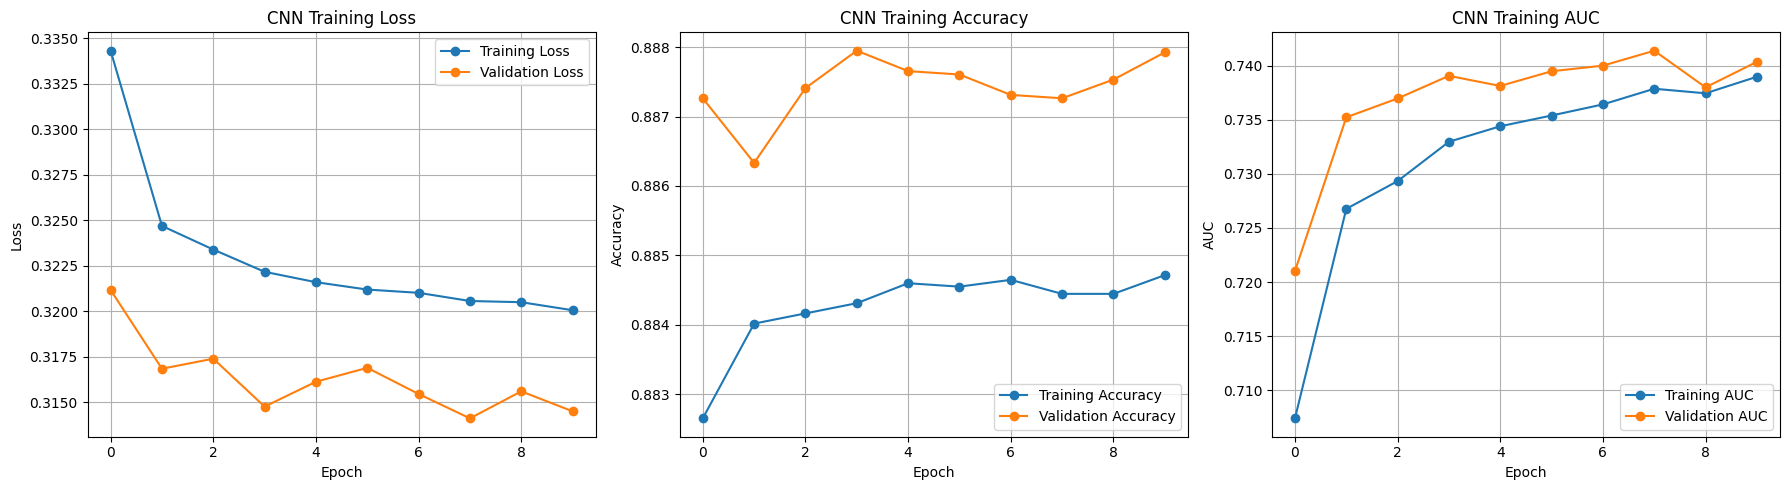

In [12]:
# Plot CNN training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(cnn_history.history['loss'], label='Training Loss', marker='o')
axes[0].plot(cnn_history.history['val_loss'], label='Validation Loss', marker='o')
axes[0].set_title('CNN Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(cnn_history.history['accuracy'], label='Training Accuracy', marker='o')
axes[1].plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[1].set_title('CNN Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

# AUC
if 'auc' in cnn_history.history:
    axes[2].plot(cnn_history.history['auc'], label='Training AUC', marker='o')
    axes[2].plot(cnn_history.history['val_auc'], label='Validation AUC', marker='o')
    axes[2].set_title('CNN Training AUC')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid(True)

plt.tight_layout()
plt.show()

In [14]:
# COMPREHENSIVE COMPARISON
print("\n" + "="*60)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*60)

# Calculate metrics for all models
comparison_metrics = []

for model_name, result in results.items():
    y_pred = result['predictions']
    y_pred_proba = result['probabilities']
    
    # Calculate metrics
    accuracy = np.mean(y_pred == y_test)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_pred_proba)
    
    comparison_metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc,
        'Training Time (s)': training_times.get(model_name, 0)
    })

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_metrics)
comparison_df = comparison_df.round(4)

print("\nPerformance Comparison:")
print(comparison_df.to_string(index=False))


COMPREHENSIVE MODEL COMPARISON

Performance Comparison:
              Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  Training Time (s)
Logistic Regression    0.6662     0.2130  0.6953    0.3261   0.7411             0.1089
      Random Forest    0.7214     0.2370  0.6304    0.3445   0.7452             3.5074
            XGBoost    0.6931     0.2235  0.6640    0.3344   0.7443             0.8967
             1D CNN    0.8854     0.5557  0.0673    0.1200   0.7478            94.5116


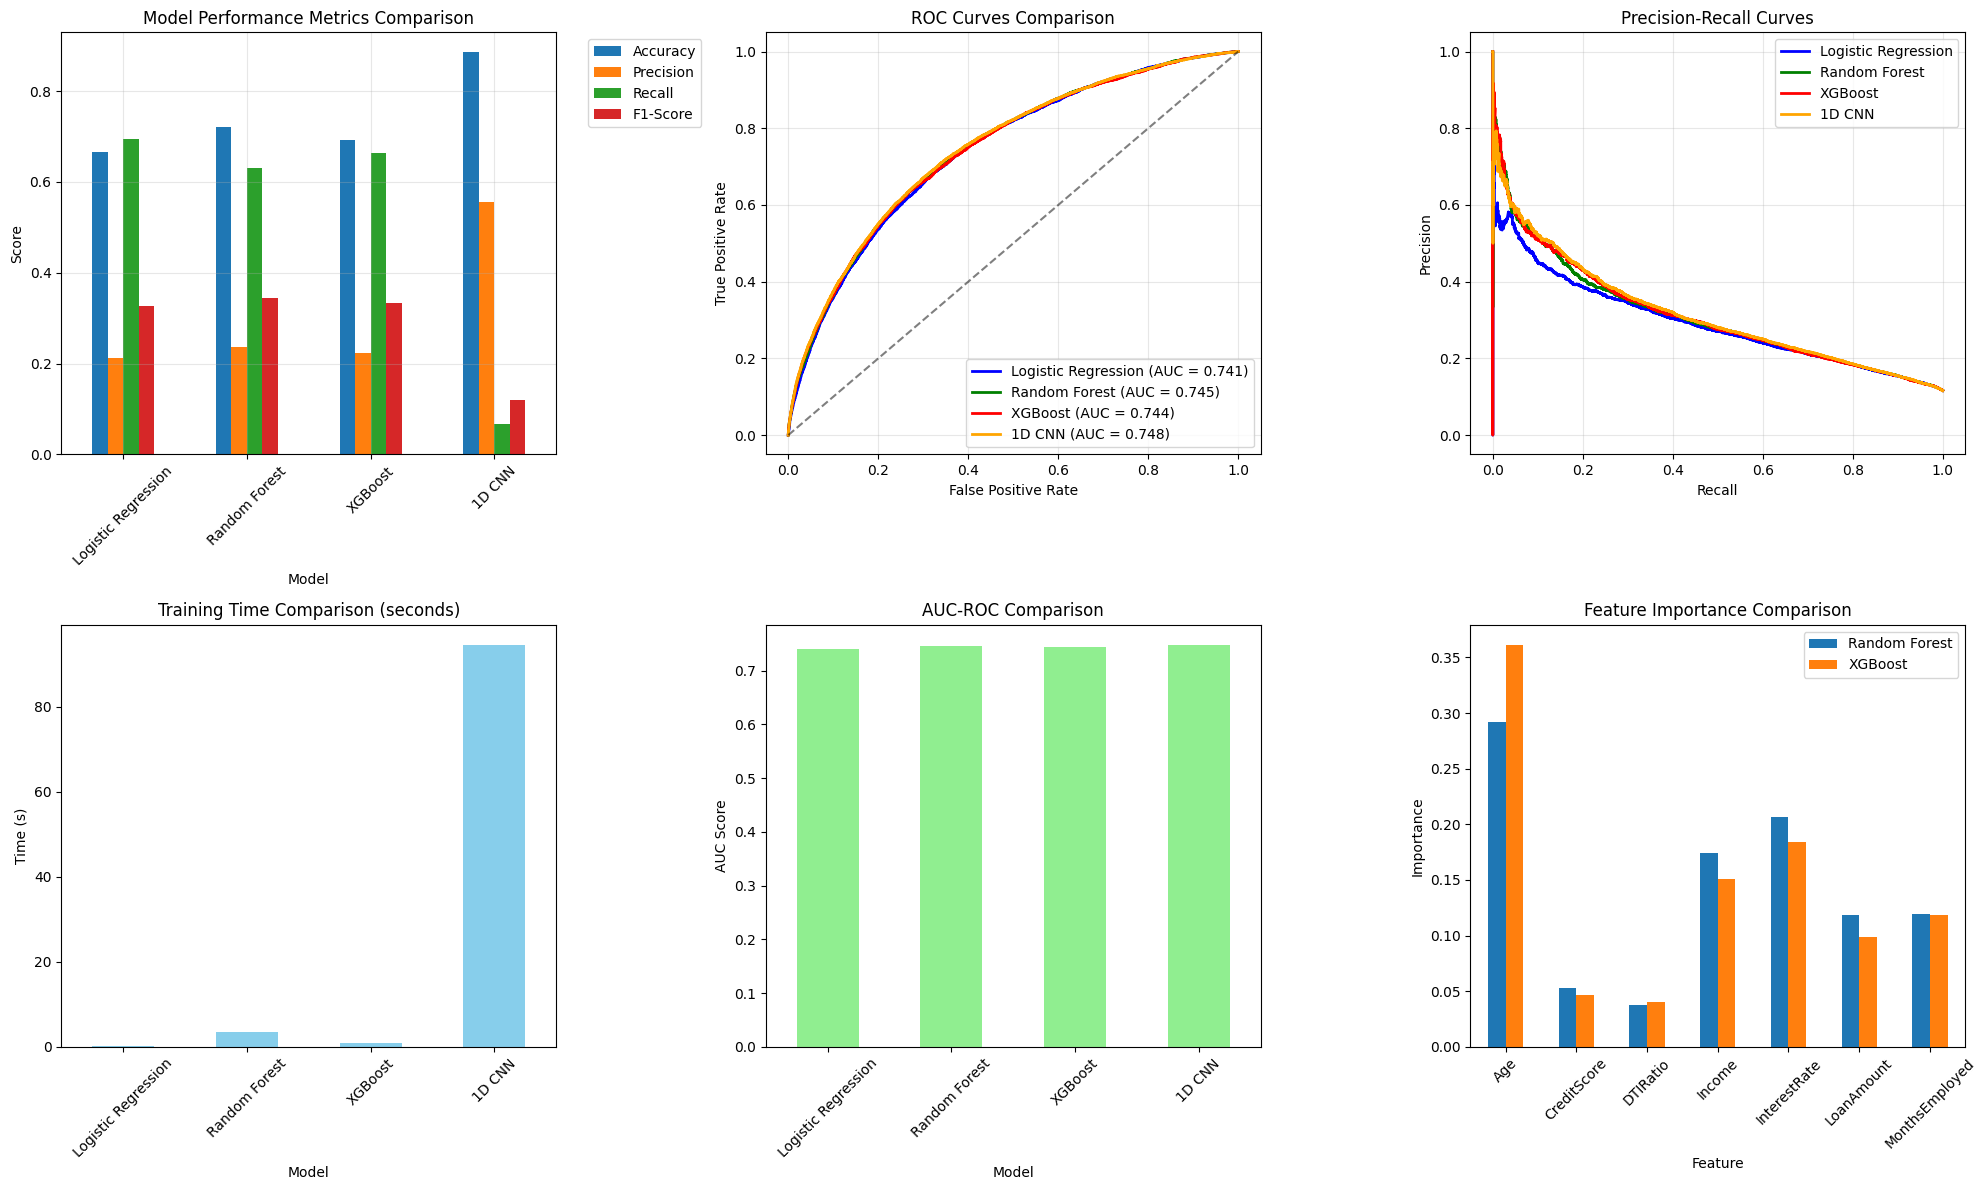


DETAILED CLASSIFICATION REPORTS

Logistic Regression:
-------------------
              precision    recall  f1-score   support

  No Default       0.94      0.66      0.78     45139
     Default       0.21      0.70      0.33      5931

    accuracy                           0.67     51070
   macro avg       0.58      0.68      0.55     51070
weighted avg       0.86      0.67      0.73     51070


Random Forest:
-------------
              precision    recall  f1-score   support

  No Default       0.94      0.73      0.82     45139
     Default       0.24      0.63      0.34      5931

    accuracy                           0.72     51070
   macro avg       0.59      0.68      0.58     51070
weighted avg       0.86      0.72      0.77     51070


XGBoost:
-------
              precision    recall  f1-score   support

  No Default       0.94      0.70      0.80     45139
     Default       0.22      0.66      0.33      5931

    accuracy                           0.69     51070
   ma

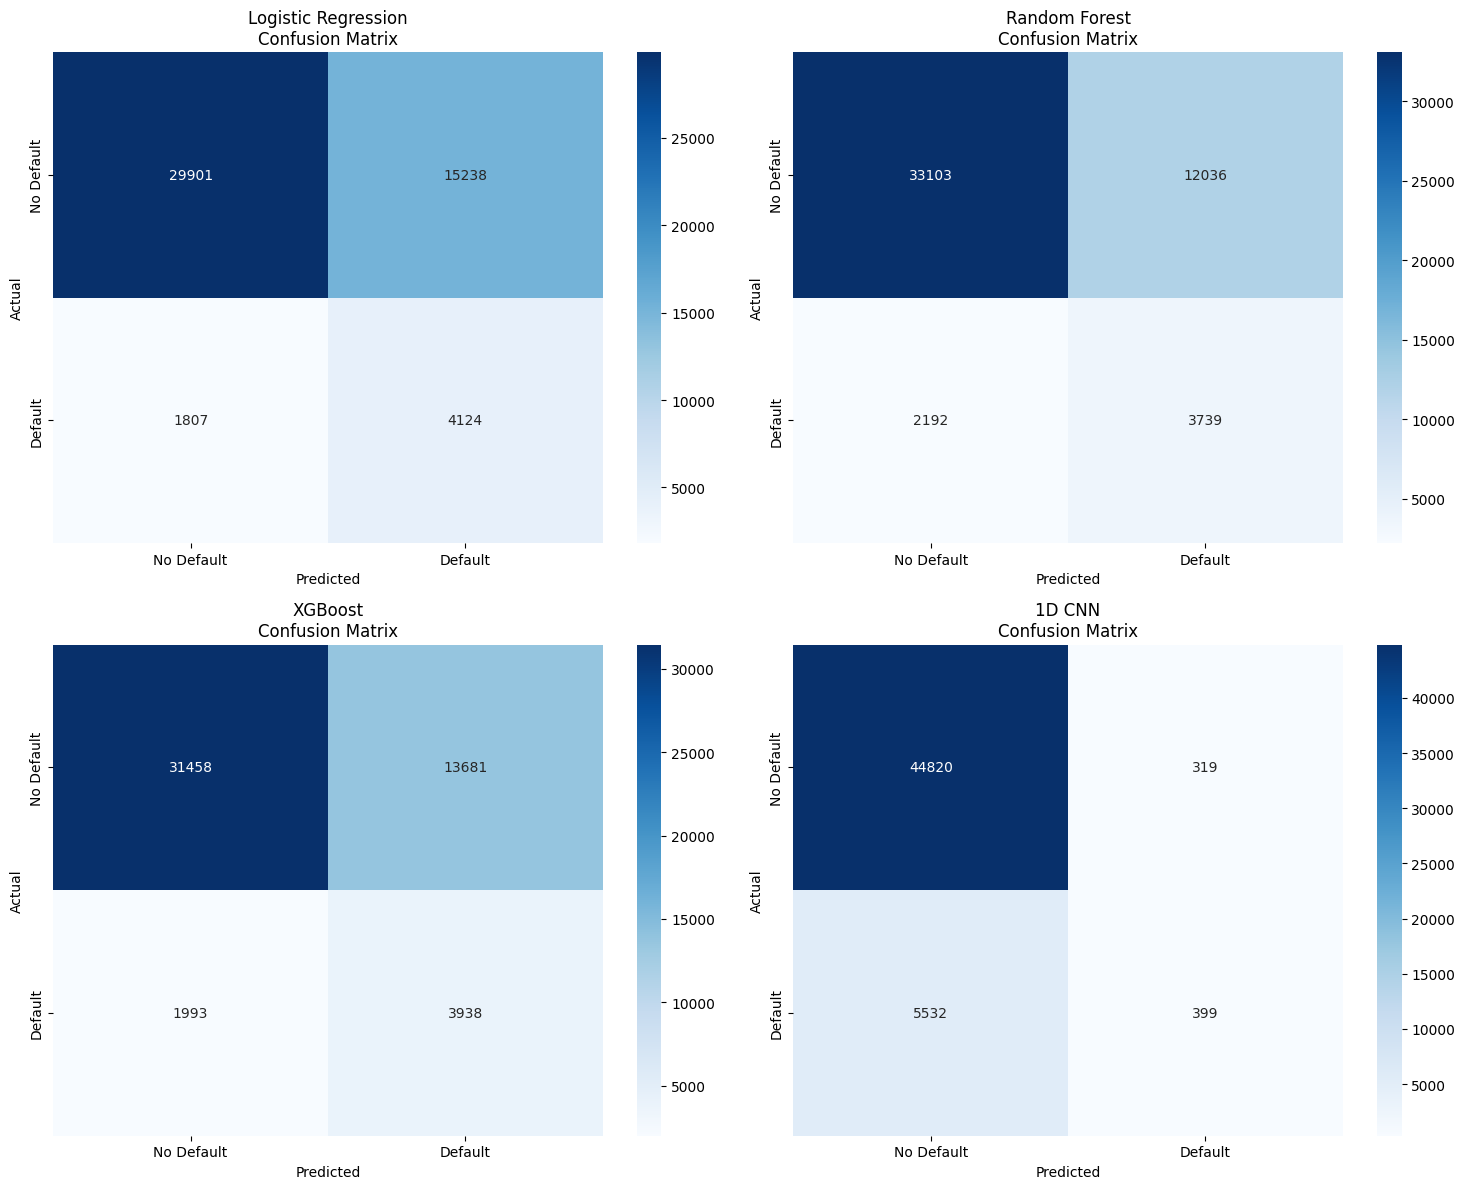

In [15]:
# VISUALIZATIONS
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Metrics Comparison Bar Plot
metrics_plot = comparison_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
metrics_plot.plot(kind='bar', ax=axes[0,0], rot=45)
axes[0,0].set_title('Model Performance Metrics Comparison')
axes[0,0].set_ylabel('Score')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. ROC Curves
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, (model_name, result) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    auc_score = roc_auc_score(y_test, result['probabilities'])
    axes[0,1].plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', color=colors[i], linewidth=2)

axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves Comparison')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Precision-Recall Curves
for i, (model_name, result) in enumerate(results.items()):
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['probabilities'])
    axes[0,2].plot(recall_curve, precision_curve, label=model_name, color=colors[i], linewidth=2)

axes[0,2].set_xlabel('Recall')
axes[0,2].set_ylabel('Precision')
axes[0,2].set_title('Precision-Recall Curves')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Training Time Comparison
training_time_df = comparison_df[['Model', 'Training Time (s)']].set_index('Model')
training_time_df.plot(kind='bar', ax=axes[1,0], color='skyblue', legend=False)
axes[1,0].set_title('Training Time Comparison (seconds)')
axes[1,0].set_ylabel('Time (s)')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. AUC Comparison
auc_df = comparison_df[['Model', 'AUC-ROC']].set_index('Model')
auc_df.plot(kind='bar', ax=axes[1,1], color='lightgreen', legend=False)
axes[1,1].set_title('AUC-ROC Comparison')
axes[1,1].set_ylabel('AUC Score')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Feature Importance (for tree-based models)
feature_importance_data = []
for model_name in ['Random Forest', 'XGBoost']:
    if model_name in results:
        model = results[model_name]['model']
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            for feature, importance in zip(selected_features, importances):
                feature_importance_data.append({
                    'Model': model_name,
                    'Feature': feature,
                    'Importance': importance
                })

if feature_importance_data:
    importance_df = pd.DataFrame(feature_importance_data)
    pivot_importance = importance_df.pivot(index='Feature', columns='Model', values='Importance')
    pivot_importance.plot(kind='bar', ax=axes[1,2])
    axes[1,2].set_title('Feature Importance Comparison')
    axes[1,2].set_ylabel('Importance')
    axes[1,2].tick_params(axis='x', rotation=45)
    axes[1,2].legend()

plt.tight_layout()
plt.show()

# DETAILED CLASSIFICATION REPORTS
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORTS")
print("="*60)

for model_name, result in results.items():
    print(f"\n{model_name}:")
    print("-" * len(model_name))
    print(classification_report(y_test, result['predictions'], target_names=['No Default', 'Default']))

# CONFUSION MATRICES
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (model_name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'],
                ax=axes[idx])
    axes[idx].set_title(f'{model_name}\nConfusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide empty subplot if needed
if len(results) < 4:
    for idx in range(len(results), 4):
        axes[idx].set_visible(False)

plt.tight_layout()
plt.show()